<a href="https://colab.research.google.com/github/elisasmenendez/alfabeto-libras/blob/main/Reconhecimento_de_letras_est%C3%A1ticas_do_alfabeto_em_Libras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install

In [ ]:
!pip install -q mediapipe==0.10.5
!wget -q https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 20.2 MB/s eta 0:00:00


# Imports

In [ ]:
import glob
import zipfile
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pickle

import mediapipe as mp
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# Dataset download

In [ ]:
!wget -P /content/dataset https://github.com/elisasmenendez/alfabeto-libras/raw/refs/heads/main/Dataset/A-samples.zip
!wget -P /content/dataset https://github.com/elisasmenendez/alfabeto-libras/raw/refs/heads/main/Dataset/B-samples.zip
!wget -P /content/dataset https://github.com/elisasmenendez/alfabeto-libras/raw/refs/heads/main/Dataset/C-samples.zip
!wget -P /content/dataset https://github.com/elisasmenendez/alfabeto-libras/raw/refs/heads/main/Dataset/D-samples.zip
!wget -P /content/dataset https://github.com/elisasmenendez/alfabeto-libras/raw/refs/heads/main/Dataset/E-samples.zip
!wget -P /content/dataset https://github.com/elisasmenendez/alfabeto-libras/raw/refs/heads/main/Dataset/F-samples.zip
!wget -P /content/dataset https://github.com/elisasmenendez/alfabeto-libras/raw/refs/heads/main/Dataset/G-samples.zip
!wget -P /content/dataset https://github.com/elisasmenendez/alfabeto-libras/raw/refs/heads/main/Dataset/I-samples.zip
!wget -P /content/dataset https://github.com/elisasmenendez/alfabeto-libras/raw/refs/heads/main/Dataset/L-samples.zip
!wget -P /content/dataset https://github.com/elisasmenendez/alfabeto-libras/raw/refs/heads/main/Dataset/M-samples.zip
!wget -P /content/dataset https://github.com/elisasmenendez/alfabeto-libras/raw/refs/heads/main/Dataset/N-samples.zip
!wget -P /content/dataset https://github.com/elisasmenendez/alfabeto-libras/raw/refs/heads/main/Dataset/O-samples.zip
!wget -P /content/dataset https://github.com/elisasmenendez/alfabeto-libras/raw/refs/heads/main/Dataset/P-samples.zip
!wget -P /content/dataset https://github.com/elisasmenendez/alfabeto-libras/raw/refs/heads/main/Dataset/Q-samples.zip
!wget -P /content/dataset https://github.com/elisasmenendez/alfabeto-libras/raw/refs/heads/main/Dataset/R-samples.zip
!wget -P /content/dataset https://github.com/elisasmenendez/alfabeto-libras/raw/refs/heads/main/Dataset/S-samples.zip
!wget -P /content/dataset https://github.com/elisasmenendez/alfabeto-libras/raw/refs/heads/main/Dataset/T-samples.zip
!wget -P /content/dataset https://github.com/elisasmenendez/alfabeto-libras/raw/refs/heads/main/Dataset/U-samples.zip
!wget -P /content/dataset https://github.com/elisasmenendez/alfabeto-libras/raw/refs/heads/main/Dataset/V-samples.zip
!wget -P /content/dataset https://github.com/elisasmenendez/alfabeto-libras/raw/refs/heads/main/Dataset/W-samples.zip
!wget -P /content/dataset https://github.com/elisasmenendez/alfabeto-libras/raw/refs/heads/main/Dataset/Y-samples.zip

In [ ]:
for file_name in glob.glob("/content/dataset/*-samples.zip"):
  with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall(file_name.replace('.zip',''))

# Mediapipe test

We implemented some functions to visualize the hand landmark detection results. Run the following cell to activate the functions.


In [ ]:
MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green

def draw_landmarks_on_image(rgb_image, detection_result):
  hand_landmarks_list = detection_result.hand_landmarks
  handedness_list = detection_result.handedness
  annotated_image = np.copy(rgb_image)

  # Loop through the detected hands to visualize.
  for idx in range(len(hand_landmarks_list)):
    hand_landmarks = hand_landmarks_list[idx]
    handedness = handedness_list[idx]

    # Draw the hand landmarks.
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      hand_landmarks_proto,
      solutions.hands.HAND_CONNECTIONS,
      solutions.drawing_styles.get_default_hand_landmarks_style(),
      solutions.drawing_styles.get_default_hand_connections_style())

    # Get the top left corner of the detected hand's bounding box.
    height, width, _ = annotated_image.shape
    x_coordinates = [landmark.x for landmark in hand_landmarks]
    y_coordinates = [landmark.y for landmark in hand_landmarks]
    text_x = int(min(x_coordinates) * width)
    text_y = int(min(y_coordinates) * height) - MARGIN

    # Draw handedness (left or right hand) on the image.
    cv2.putText(annotated_image, f"{handedness[0].category_name}",
                (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

  return annotated_image

Here are the steps to run hand landmark detection using MediaPipe.

Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/hand_landmarker/python) to learn more about configuration options that this solution supports.


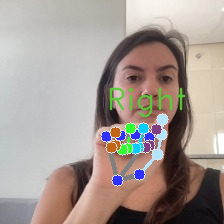

In [ ]:
fileImg = "/content/dataset/A-samples/10.jpg"
img = cv2.imread(fileImg)

# STEP 2: Create an HandLandmarker object.
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options, num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file(fileImg)

# STEP 4: Detect hand landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the classification result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

# Get raw keypoints

In [ ]:
# Create an HandLandmarker object.
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options, num_hands=1)
detector = vision.HandLandmarker.create_from_options(options)

In [ ]:
# Setting the keypoints file name
keypoints_file = "/content/right_hand_keypoints.csv"

# Create keypoints file
f = open(keypoints_file, "a")

samples_path = "/content/dataset/"
path_len = len(samples_path)

# Iterate throught images - this takes 5 minutes
for file_name in glob.glob(samples_path + "*-samples/*.jpg"):

  letter = file_name[path_len:path_len+1]

  # if letter not in ['A','B','C','D']:
  #   continue

  image_name = file_name[path_len:]

  print(image_name)

  # Running model
  image = mp.Image.create_from_file(file_name)
  detection_result = detector.detect(image)

  # Continue if hand is not detected
  if not detection_result.hand_landmarks:
    continue

  # Only the right hand for now
  hand_landmarks = detection_result.hand_landmarks[0]

  # Create sequence with x, y and z points
  sequence = []
  sequence.append(image_name)
  sequence.append(letter)

  for landmark in hand_landmarks:
    sequence.append(landmark.x)
    sequence.append(landmark.y)
    sequence.append(landmark.z)

  str_list = [str(value) for value in sequence]
  csv_string = ','.join(str_list) + '\n'
  f.write(csv_string)

f.close()

In [ ]:
df = pd.read_csv(keypoints_file, header=None)
df[1].value_counts()

,count
1,
C,200
N,200
D,200
U,200
V,200
A,200
E,200
L,200
R,200


# Pre-Processing

Get a new normalized points regarding the hand frame

In [ ]:
!wget https://github.com/elisasmenendez/alfabeto-libras/raw/refs/heads/main/right_hand_keypoints.csv

--2024-10-01 17:12:03--  https://github.com/elisasmenendez/alfabeto-libras/raw/refs/heads/main/right_hand_keypoints.csv
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/elisasmenendez/alfabeto-libras/refs/heads/main/right_hand_keypoints.csv [following]
--2024-10-01 17:12:04--  https://raw.githubusercontent.com/elisasmenendez/alfabeto-libras/refs/heads/main/right_hand_keypoints.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5343515 (5.1M) [text/plain]
Saving to: ‘right_hand_keypoints.csv.1’

right_hand_keypoint 100%[===================>]   5.10M  --.-KB/s    in 0.06s   

2024-10-01 17:12:04 (

In [ ]:
df = pd.read_csv('/content/right_hand_keypoints.csv', header=None)
df[1].value_counts()

,count
1,
C,200
N,200
D,200
U,200
V,200
A,200
E,200
L,200
R,200


In [ ]:
one_rows_idx = df[df[1] == "1"].index
df.drop(one_rows_idx , inplace=True)

In [ ]:
new_df = pd.DataFrame()

In [ ]:
width = 224
height = 224

for index, row in df.iterrows():
  min_x = 1
  max_x = 0

  for i in range (0,21):
    x = row[(i*3)+2]
    if x < min_x:
      min_x = x
    if x > max_x:
      max_x = x

  min_y = 1
  max_y = 0
  for i in range (0,21):
    y = row[(i*3)+2+1]
    if y < min_y:
      min_y = y
    if y > max_y:
      max_y = y

  norm_min_x = math.floor(min_x * width)
  norm_max_x = math.ceil(max_x * width)
  norm_min_y = math.floor(min_y * height)
  norm_max_y = math.ceil(max_y * height)
  new_width = norm_max_x - norm_min_x + 2
  new_height = norm_max_y - norm_min_y + 2

  new_row = df.iloc[index].copy()

  for i in range (0,21):
    x = row[(i*3)+2] * width
    y = row[(i*3)+2+1] * height
    new_norm_x = (x - norm_min_x) / new_width
    new_norm_y = (y - norm_min_y) / new_height

    new_row[(i*3)+2] = new_norm_x
    new_row[(i*3)+2+1] = new_norm_y

  new_df = pd.concat([new_df, pd.DataFrame([new_row])], ignore_index=True)


  print(index)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,S-samples/108.jpg,S,0.384314,0.711239,-2.020943e-07,0.464013,0.688447,-0.020752,0.522846,0.616195,...,-0.038844,0.372629,0.524555,-0.058284,0.375150,0.574773,-0.039696,0.359976,0.587212,-0.021741
1,S-samples/1.jpg,S,0.298984,0.620542,-8.671483e-08,0.355319,0.562113,-0.015425,0.377413,0.480031,...,-0.023213,0.233659,0.464267,-0.037291,0.249306,0.502501,-0.021856,0.247086,0.520161,-0.006228
2,S-samples/191.jpg,S,0.264284,0.685094,-2.883208e-08,0.334034,0.658075,-0.022148,0.372733,0.590375,...,-0.011992,0.252085,0.528568,-0.029377,0.250235,0.562265,-0.021300,0.249902,0.583274,-0.010137
3,S-samples/116.jpg,S,0.415269,0.763951,-1.187798e-07,0.502488,0.734698,-0.023821,0.578447,0.655616,...,-0.047806,0.411566,0.549340,-0.067068,0.415531,0.602857,-0.050623,0.397226,0.607703,-0.035930
4,S-samples/30.jpg,S,0.605469,0.562241,-1.083351e-09,0.700673,0.497800,-0.021373,0.776148,0.399836,...,-0.038839,0.575164,0.311576,-0.064960,0.589747,0.373453,-0.048678,0.571212,0.386100,-0.031973


In [ ]:
new_df.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,S-samples/108.jpg,S,0.241010,0.949389,-2.020943e-07,0.629108,0.853057,-0.020752,0.915596,0.547690,...,-0.038844,0.184105,0.160385,-0.058284,0.196382,0.372627,-0.039696,0.122490,0.425199,-0.021741
1,S-samples/1.jpg,S,0.472958,0.948300,-8.671483e-08,0.805039,0.722645,-0.015425,0.935275,0.405637,...,-0.023213,0.087886,0.344754,-0.037291,0.180121,0.492417,-0.021856,0.167035,0.560623,-0.006228
2,S-samples/191.jpg,S,0.158962,0.944804,-2.883208e-08,0.559579,0.813235,-0.022148,0.781849,0.483565,...,-0.011992,0.088900,0.182592,-0.029377,0.078274,0.346680,-0.021300,0.076361,0.448986,-0.010137
3,S-samples/116.jpg,S,0.231159,0.952871,-1.187798e-07,0.606873,0.845447,-0.023821,0.934080,0.555050,...,-0.047806,0.215207,0.164789,-0.067068,0.232288,0.361313,-0.050623,0.153435,0.379106,-0.035930
4,S-samples/30.jpg,S,0.348792,0.971808,-1.083351e-09,0.692756,0.774072,-0.021373,0.965437,0.473469,...,-0.038839,0.239302,0.202644,-0.064960,0.291989,0.392514,-0.048678,0.225025,0.431319,-0.031973


# Training

In [ ]:
# Convert classes labels to numeric
map = pd.factorize(new_df[1])
new_df[1] = map[0]

In [ ]:
for i in range(0,21):
  print(i, map[1][i])

0 S
1 Y
2 F
3 Q
4 O
5 M
6 I
7 B
8 G
9 W
10 C
11 N
12 P
13 R
14 L
15 E
16 A
17 V
18 U
19 D
20 T


In [ ]:
# Separate attributes and classes
X_df = new_df.iloc[:,2:].values
y_df = new_df.iloc[:,1].values

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.25, random_state=0)

A simple RandomForest solved

In [ ]:
model = RandomForestClassifier()

In [ ]:
model.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
y_predict = model.predict(X_test)

score = accuracy_score(y_predict, y_test)

print('{}% of samples were classified correctly !'.format(score * 100))

99.61868446139181% of samples were classified correctly !


In [ ]:
# Save the model
filename = 'randomforest.sav'
pickle.dump(model, open(filename, 'wb'))

# Save the map
filename = 'map.sav'
pickle.dump(map, open(filename, 'wb'))

## Confusion matrix

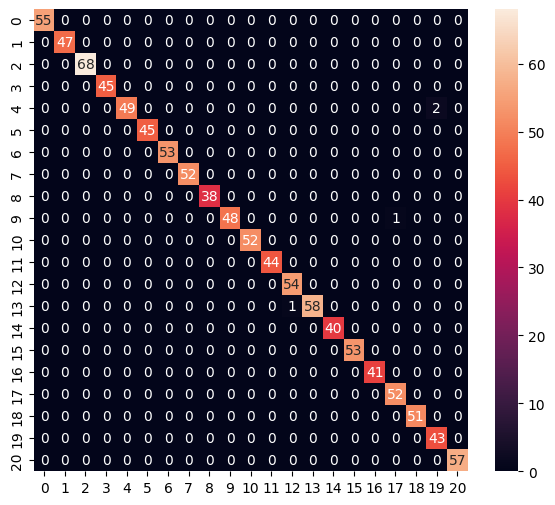

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        55
           1       1.00      1.00      1.00        47
           2       1.00      1.00      1.00        68
           3       1.00      1.00      1.00        45
           4       1.00      0.96      0.98        51
           5       1.00      1.00      1.00        45
           6       1.00      1.00      1.00        53
           7       1.00      1.00      1.00        52
           8       1.00      1.00      1.00        38
           9       1.00      0.98      0.99        49
          10       1.00      1.00      1.00        52
          11       1.00      1.00      1.00        44
          12       0.98      1.00      0.99        54
          13       1.00      0.98      0.99        59
          14       1.00      1.00      1.00        40
          15       1.00      1.00      1.00        53
          16       1.00      1.00      1.00        41
     

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()

    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)

print_confusion_matrix(y_test, Y_pred)

# Testing

In [ ]:
NEW_WIDTH = 400
def resize_image(image):
  height, width, _ = image.shape
  if width > NEW_WIDTH:
      new_height = int((height / width) * NEW_WIDTH)
      resized_image = cv2.resize(image, (NEW_WIDTH, new_height))
      return resized_image
  return image

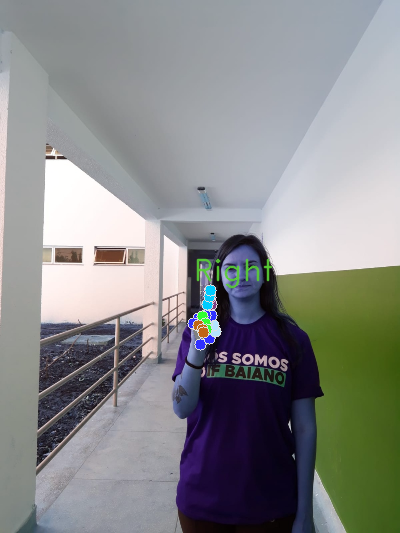

In [ ]:
fileImg = "/content/WhatsApp Image 2024-07-12 at 11.11.45 (1).jpeg"

img = cv2.imread(fileImg)

# STEP 3: Load the input image.
resized_image = resize_image(img)

mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))

detection_result = detector.detect(mp_image)

# STEP 5: Process the classification result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(resized_image, detection_result)
cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))


In [ ]:
# Only the right hand for now
hand_landmarks = detection_result.hand_landmarks[0]
height, width, _ = img.shape

x_coordinates = [landmark.x for landmark in hand_landmarks]
y_coordinates = [landmark.y for landmark in hand_landmarks]
z_coordinates = [landmark.z for landmark in hand_landmarks]

norm_min_x = math.floor((min(x_coordinates) * width))
norm_min_y = math.floor((min(y_coordinates) * height))
norm_max_x = math.ceil((max(x_coordinates) * width))
norm_max_y = math.ceil((max(y_coordinates) * height))

new_width = norm_max_x - norm_min_x + 2
new_height = norm_max_y - norm_min_y + 2

cropped_hand_keypoints = []

for i in range (0,21):
  x = x_coordinates[i] * width
  y = y_coordinates[i] * height
  new_norm_x = (x - norm_min_x) / new_width
  new_norm_y = (y - norm_min_y) / new_height

  cropped_hand_keypoints.append(new_norm_x)
  cropped_hand_keypoints.append(new_norm_y)
  cropped_hand_keypoints.append(z_coordinates[i])

cropped_hand_keypoints

test = model.predict([cropped_hand_keypoints])
map[1][test[0]]

'R'

# Processing video

In [ ]:
# Setup
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options, num_hands=1)
detector = vision.HandLandmarker.create_from_options(options)

NEW_WIDTH = 400
FONT_SIZE = 1
FONT_THICKNESS = 2
HANDEDNESS_TEXT_COLOR = (0, 0, 0) # black

model_filename = 'randomforest.sav'
model = pickle.load(open(model_filename, 'rb'))
map_filename = 'map.sav'
map = pickle.load(open(map_filename, 'rb'))

def resize_image(image):
  height, width, _ = image.shape
  if width > NEW_WIDTH:
      new_height = int((height / width) * NEW_WIDTH)
      resized_image = cv2.resize(image, (NEW_WIDTH, new_height))
      return resized_image
  return image

def get_cropped_hand(detection_result, image):

  # Only the right hand for now
  hand_landmarks = detection_result.hand_landmarks[0]

  x_coordinates = [landmark.x for landmark in hand_landmarks]
  y_coordinates = [landmark.y for landmark in hand_landmarks]
  z_coordinates = [landmark.z for landmark in hand_landmarks]

  height, width, _ = image.shape

  norm_min_x = math.floor((min(x_coordinates) * width))
  norm_min_y = math.floor((min(y_coordinates) * height))
  norm_max_x = math.ceil((max(x_coordinates) * width))
  norm_max_y = math.ceil((max(y_coordinates) * height))

  new_width = norm_max_x - norm_min_x + 2
  new_height = norm_max_y - norm_min_y + 2

  cropped_hand_keypoints = []

  for i in range (0,21):
    x = x_coordinates[i] * width
    y = y_coordinates[i] * height
    new_norm_x = (x - norm_min_x) / new_width
    new_norm_y = (y - norm_min_y) / new_height

    cropped_hand_keypoints.append(new_norm_x)
    cropped_hand_keypoints.append(new_norm_y)
    cropped_hand_keypoints.append(z_coordinates[i])

  return cropped_hand_keypoints

def write_letter(image, letter):
  annotated_image = np.copy(image)
  cv2.putText(annotated_image, letter,
        (50, 50), cv2.FONT_HERSHEY_DUPLEX,
        FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

  return annotated_image

def create_new_video(file_name, new_frames):

  height, width, _ = new_frames[0].shape

  new_video = cv2.VideoWriter(file_name, cv2.VideoWriter_fourcc(*'XVID'), 30, (width, height))
  for frame in new_frames:
    new_video.write(frame)

  new_video.release()

In [ ]:
video_file = '/content/Macambira.mov'

new_frames = []
letters = []

# Open the video file
cap = cv2.VideoCapture(video_file)

# Read the first frame
success, frame = cap.read()

# For each frame
while success:

  resized_image = resize_image(frame)

  mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))

  detection_result = detector.detect(mp_image)

  # Continue if hand is not detected
  if not detection_result.hand_landmarks:
    success,frame = cap.read()
    continue

  cropped_hand = get_cropped_hand(detection_result,resized_image)

  prediction = model.predict([cropped_hand])[0]

  letter = map[1][prediction]

  letters.append(letter)

  print(letter)

  annotated_image = write_letter(resized_image, letter)

  new_frames.append(annotated_image)

  success,frame = cap.read()

# Clean up
cap.release()

M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
Q
Q
A
A
A
A
S
S
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
S
S
O
O
O
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
O
O
O
E
E
E
E
O
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
S
S
S
S
D
S
Q
Q
Q
Q
M
N
N
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
Q
Q
S
S
S
S
E
E
E
E
E
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
E
E
E
E
E
E
I
I
I
I
I
I
I
I
I
I
I
I
I
I
I
I
I
I
I
I
I
I
I
I
I
I
I
I
I
E
S
S
S
S
S
S
S
R
R
R
R
R
R
R
R
R
R
R
R
R
R
R
R
R
R
R
R
R
R
R
R
R
R
R
R
R
R
R
R
R
R
R
R
R
R
S
E
E
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A


In [ ]:
create_new_video("Macambira_alfabeto.mp4", new_frames)